Prepare maps for analysis
- convert to z map
- check MNI space

Hypotheses:

Parametric effect of gain:

1. Positive effect in ventromedial PFC - for the equal indifference group
2. Positive effect in ventromedial PFC - for the equal range group
3. Positive effect in ventral striatum - for the equal indifference group
4. Positive effect in ventral striatum - for the equal range group

Parametric effect of loss:
- 5: Negative effect in VMPFC - for the equal indifference group
- 6: Negative effect in VMPFC - for the equal range group
- 7: Positive effect in amygdala - for the equal indifference group
- 8: Positive effect in amygdala - for the equal range group

Equal range vs. equal indifference:

- 9: Greater positive response to losses in amygdala for equal range condition vs. equal indifference condition.


In [1]:
import numpy,pandas
import nibabel
import json
import os,glob
import nilearn.image
import nilearn.input_data
import nilearn.plotting
from collections import OrderedDict
import shutil
import warnings
import sklearn
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

hypotheses= {1:'+gain: equal indiff',
            2:'+gain: equal range',
            3:'+gain: equal indiff',
            4:'+gain: equal range',
            5:'-loss: equal indiff',
            6:'-loss: equal range',
            7:'+loss: equal indiff',
            8:'+loss: equal range',
            9:'+loss:ER>EI'}


/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(k

In [2]:
from templateflow.api import get
get('MNI152NLin2009cAsym', **{'from': 'MNI152NLin6Asym'})


Failed to import duecredit due to No module named 'duecredit'


PosixPath('/Users/poldrack/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_from-MNI152NLin6Asym_mode-image_xfm.h5')

### loading the metadata


In [3]:
metadata_file = '/Users/poldrack/data_unsynced/NARPS/analysis_pipelines.xlsx'
metadata = pandas.read_excel(metadata_file,header=1)
metadata.shape

(70, 39)

In [4]:
metadata.columns

Index(['teamID', 'NV_collection_string', 'results_comments', 'preregistered',
       'link_preregistration_form', 'regions_definition', 'softwares',
       'n_participants', 'exclusions_details', 'used_fmriprep_data',
       'preprocessing_order', 'brain_extraction', 'segmentation',
       'slice_time_correction', 'motion_correction',
       'gradient_distortion_correction', 'intra_subject_coreg',
       'distortion_correction', 'inter_subject_reg', 'intensity_correction',
       'intensity_normalization', 'noise_removal', 'volume_censoring',
       'spatial_smoothing', 'preprocessing_comments',
       'data_submitted_to_model', 'spatial_region_modeled',
       'independent_vars_first_level', 'independent_vars_higher_level',
       'model_type', 'model_settings', 'inference_contrast_effect',
       'search_region', 'statistic_type', 'pval_computation',
       'multiple_testing_correction', 'comments_analysis', 'general comments',
       'additional files?'],
      dtype='object')

### Processing the statistical images

In [2]:
orig_dir = '/Users/poldrack/data_unsynced/NARPS/maps/orig'
output_dir = '/Users/poldrack/data_unsynced/NARPS/maps'

input_jsons = glob.glob(os.path.join(orig_dir,'*/images.json'))
print('found',len(input_jsons),'input directories')
input_dirs = [os.path.dirname(i) for i in input_jsons]


found 60 input directories


In [6]:
# find maps
imgfile_dict = {'thresh':{},'unthresh':{}}

for i in input_dirs:
    for h in range(1,10):
        for t in ['thresh','unthresh']:
            fname=os.path.join(i,'hypo%d_%s.nii.gz'%(h,t))
            if os.path.exists(fname):
                if not i in imgfile_dict[t]:
                    imgfile_dict[t][i]={}
                imgfile_dict[t][i][h]=fname
    if i in imgfile_dict['thresh']:
        if not len(imgfile_dict['thresh'][i])==9:
            print("missing files for",i,': only',len(imgfile_dict['thresh'][i]),'found')
            del imgfile_dict['thresh'][i]
    if i in imgfile_dict['unthresh']:
        if not len(imgfile_dict['unthresh'][i])==9:
            print("missing files for",i,': only',len(imgfile_dict['unthresh'][i]),'found')
            del imgfile_dict['unthresh'][i]
for t in ['thresh','unthresh']:
    print(t,': found ',len(imgfile_dict[t]),'datasets')

thresh : found  60 datasets
unthresh : found  60 datasets


In [8]:
template_img = os.path.join(output_dir,'templates/MNI152_T1_2mm.nii.gz')

missing_images = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for i in input_dirs:
        if not (i in imgfile_dict['thresh']) or not (i in imgfile_dict['unthresh']):
            missing_images.append(i)
            continue
        if not (len(imgfile_dict['thresh'][i])==9) or not (len(imgfile_dict['unthresh'][i])==9):
            missing_images.append(i)
            continue
        # convert all to FSL space
        if 0:
            print(os.path.basename(i),': copying fmriprep data directly')
            target_dir=os.path.join(output_dir,'mnispace',os.path.basename(i))
            if not os.path.exists(target_dir):
                print('copying',i,'to',target_dir)
                shutil.copytree(i,target_dir)
        else:
            print(os.path.basename(i),':converting to FSL MNI space')
            outdir = i.replace('orig','resampled')
            if not os.path.exists(outdir):
                os.mkdir(outdir)
            for img in glob.glob(os.path.join(i,'hyp*nii.gz')):
                if os.path.basename(img).find('_thresh')>-1:
                    interp='nearest'
                else:
                    interp='continuous'
                resampled = nilearn.image.resample_to_img(img, template_img,
                                                    interpolation=interp)
                resampled.to_filename(os.path.join(outdir,os.path.basename(img)))

print('missing proper images for:')
[os.path.basename(i) for i in missing_images]

YZFBWTVU_Q6O0 :converting to FSL MNI space
FKMCNBTL_B5I6 :converting to FSL MNI space
CLTGPQPO_43FJ :converting to FSL MNI space
MQKTVNIH_08MQ :converting to FSL MNI space
RIIVGRDK_E3B6 :converting to FSL MNI space
YGVUUZDV_IZ20 :converting to FSL MNI space
JAWCZRDS_V55J :converting to FSL MNI space
MNASBORM_3PQ2 :converting to FSL MNI space
NPZYAJUF_94GU :converting to FSL MNI space
IZREEBAR_T54A :converting to FSL MNI space
CMGDLXNE_C22U :converting to FSL MNI space
COXUJKNY_R9K3 :converting to FSL MNI space
ZNLBVOZG_UK24 :converting to FSL MNI space
PVRJCPGN_X19V :converting to FSL MNI space
XTQTYBTF_0I4U :converting to FSL MNI space
QDWZHJWT_L7J7 :converting to FSL MNI space
PJLEEUYF_46CD :converting to FSL MNI space
CQCJIRXE_O03M :converting to FSL MNI space
WLJQPTCD_O6R6 :converting to FSL MNI space
LASLHJJB_I52Y :converting to FSL MNI space
WRZSQULI_B23O :converting to FSL MNI space
FLSSDFOD_9T8E :converting to FSL MNI space
QJVDBBPV_R42Q :converting to FSL MNI space
YWGVKXBZ_6F

[]

#### Combine thresholded images and create summary map

In [9]:
for hyp in range(1,10):
    hmaps = glob.glob(os.path.join(output_dir,'resampled/*/hypo%d_thresh.nii.gz'%hyp))
    print('hypo %d: found %d maps'%(hyp,len(hmaps)))
    concat_img = nilearn.image.concat_imgs(hmaps)
    concat_img.to_filename(os.path.join(output_dir,'thresh_concat/hypo%d.nii.gz'%hyp))


hypo 1: found 60 maps


/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


hypo 2: found 60 maps
hypo 3: found 60 maps
hypo 4: found 60 maps
hypo 5: found 60 maps
hypo 6: found 60 maps
hypo 7: found 60 maps
hypo 8: found 60 maps
hypo 9: found 60 maps


/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [11]:
# create overlap maps for thresholded maps

for hyp in range(1,10):
    concat_img=nibabel.load(os.path.join(output_dir,'thresh_concat/hypo%d.nii.gz'%hyp))
    concat_data = concat_img.get_data()
    concat_data = (concat_data>10e-6).astype('float')
    concat_data = numpy.nan_to_num(concat_data)
    concat_mean = numpy.mean(concat_data,3)
    concat_mean_img = nibabel.Nifti1Image(concat_mean,affine=concat_img.header.get_best_affine())
    concat_mean_img.to_filename(os.path.join(output_dir,'thresh_mean/hypo%d.nii.gz'%hyp))

/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


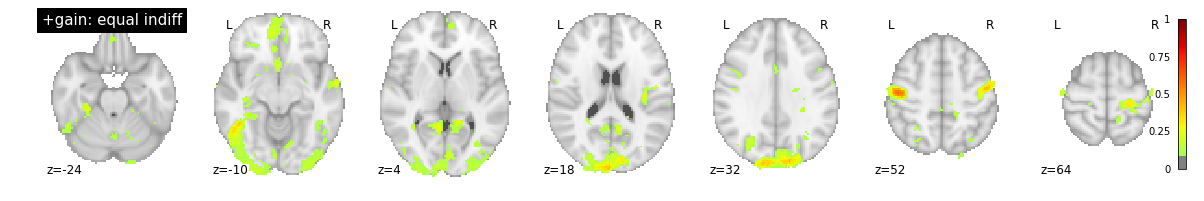

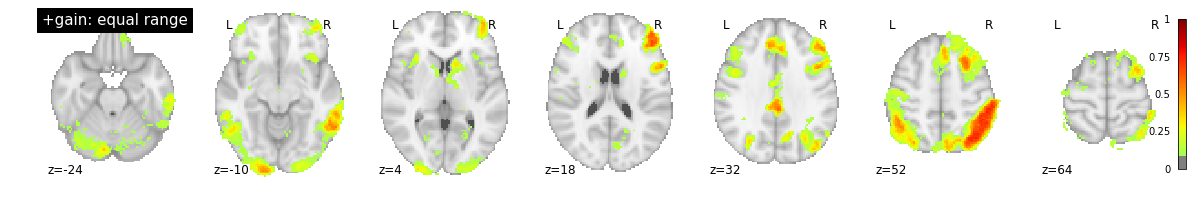

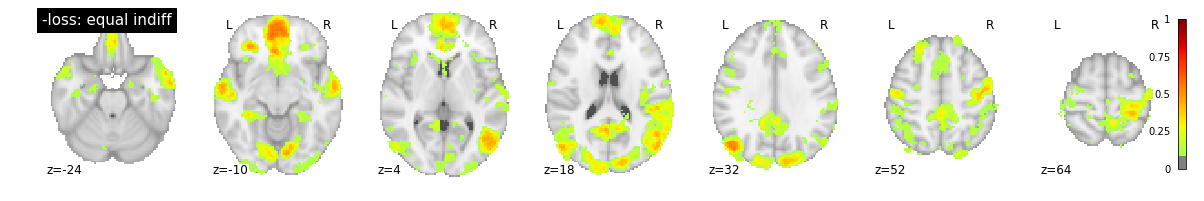

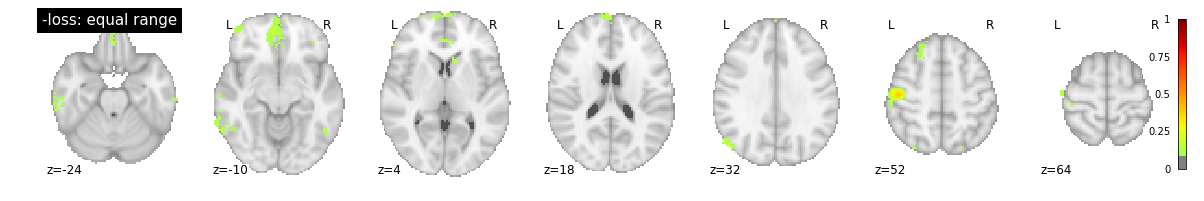

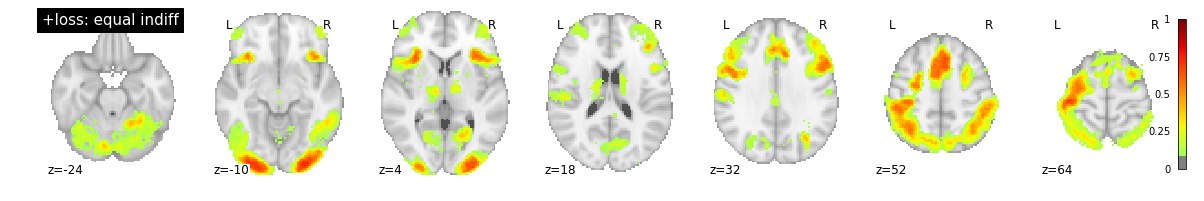

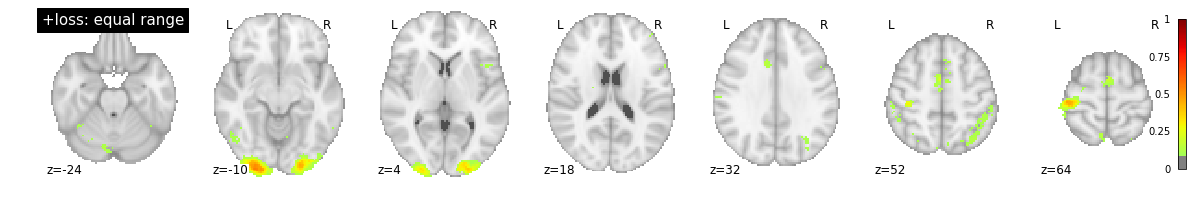

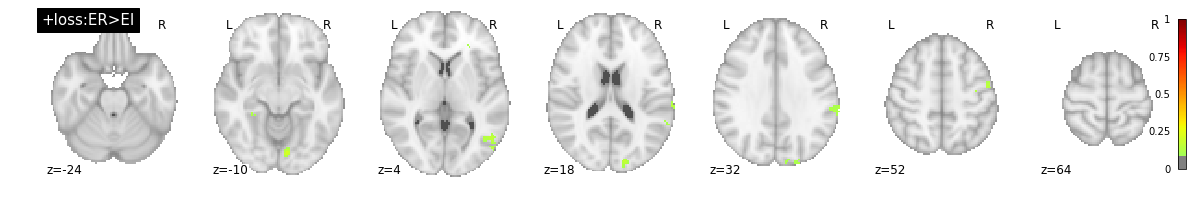

In [17]:
# display mean images

cut_coords = [-24,-10,4,18,32,52,64]
for hyp in [1,2,5,6,7,8,9]:
    img=os.path.join(output_dir,'thresh_mean/hypo%d.nii.gz'%hyp)
    nilearn.plotting.plot_stat_map(img, threshold=0.1, display_mode="z", 
                colorbar=True,title=hypotheses[hyp],vmax=1.,cmap='jet',
                                  cut_coords = cut_coords)


#### Convert all unthresholded images to Z stat images

In [50]:
# load image info from json

def get_map_types(j):
    maptypes=[]
    for img in j:
        maptypes.append(img['map_type'])
    return(list(set(maptypes)))

def parse_json(j):
    imgtype = {}
    for img in j:
        fname=os.path.basename(img['file']).replace('.nii.gz','')
        print(fname)
        f_s = fname.split('_')
        try:
            hypnum = int(f_s[0].replace('hypo',''))
            imgtype = f_s[1]
        except:
            print("something went wrong")
        print(f_s)
    return(imgtype)
        

jsonfiles = glob.glob(os.path.join(orig_dir,'*/images.json'))
print("found %d json files"%len(jsonfiles))

for j in jsonfiles:
    with open(j) as f:
        info = json.load(f)
        print(get_map_types(info))

found 60 json files
['T map']
['T map']
['parcellation', 'other']
['T map']
['ROI/mask', 'univariate-beta map', 'T map']
['ROI/mask', 'T map']
['T map']
['other']
['T map']
['other', 'univariate-beta map', 'Z map', '1-P map ("inverted" probability)']
['other']
['T map']
['parcellation', 'other', 'ROI/mask']
['other']
['parcellation', 'other']
['other']
['T map']
['parcellation', 'other']
['other']
['other']
['T map']
['T map']
['Z map']
['parcellation', 'other']
['Z map']
['other', 'T map']
['Z map']
['parcellation', 'other']
['Z map']
['other']
['Z map']
['Z map', 'other', 'T map']
['Z map']
['parcellation', 'other']
['parcellation', 'other']
['other']
['Z map']
['parcellation', 'other']
['T map']
['other']
['T map']
['ROI/mask', 'other', 'parcellation']
['T map']
['parcellation', 'other']
['other']
['parcellation', 'other']
['T map']
['other']
['T map']
['parcellation', 'other']
['Z map']
['other']
['other', 'univariate-beta map', 'Z map']
['other']
['other']
['other']
['parcellation

In [12]:
unthresh_hmaps={}
for hyp in range(1,10):
    hmaps = glob.glob(os.path.join(output_dir,'resampled/*/hypo%d_unthresh.nii.gz'%hyp))
    unthresh_hmaps[hyp]=hmaps
    print('hypo %d: found %d maps'%(hyp,len(hmaps)))
    concat_img = nilearn.image.concat_imgs(hmaps)
    concat_img.to_filename(os.path.join(output_dir,'unthresh_concat/hypo%d.nii.gz'%hyp))
    # compute range
    concat_data=numpy.nan_to_num(concat_img.get_data())
    datarange = numpy.max(concat_data,axis=3) - numpy.min(concat_data,axis=3)
    range_img = nibabel.Nifti1Image(datarange,affine=concat_img.header.get_best_affine())
    range_img.to_filename(os.path.join(output_dir,'unthresh_range/hypo%d.nii.gz'%hyp))
    datavar = numpy.std(concat_data,axis=3)
    var_img = nibabel.Nifti1Image(datavar,affine=concat_img.header.get_best_affine())
    var_img.to_filename(os.path.join(output_dir,'unthresh_std/hypo%d.nii.gz'%hyp))
    
    

hypo 1: found 60 maps


/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


hypo 2: found 60 maps
hypo 3: found 60 maps
hypo 4: found 60 maps
hypo 5: found 60 maps
hypo 6: found 60 maps
hypo 7: found 60 maps
hypo 8: found 60 maps
hypo 9: found 60 maps


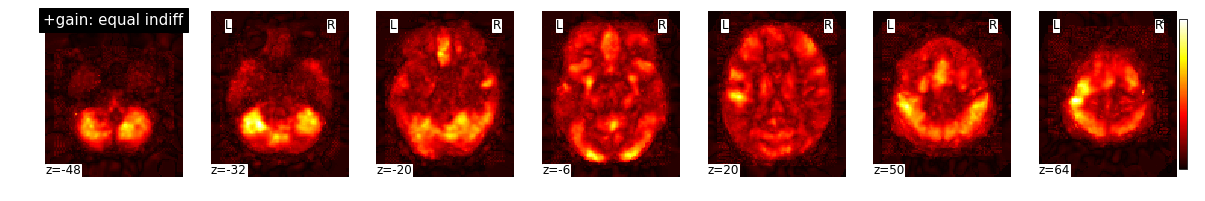

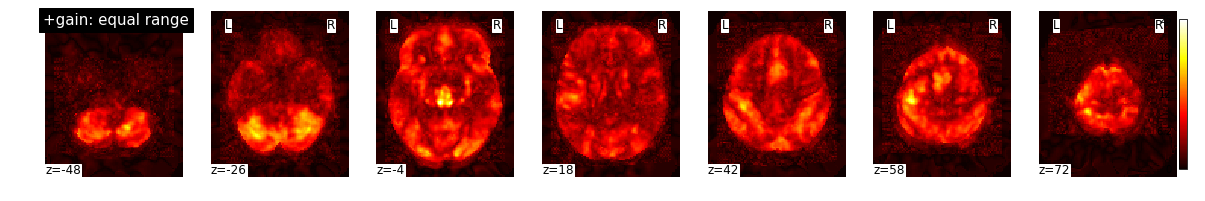

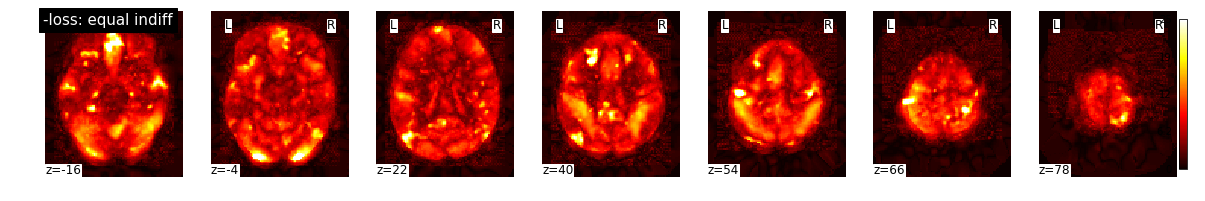

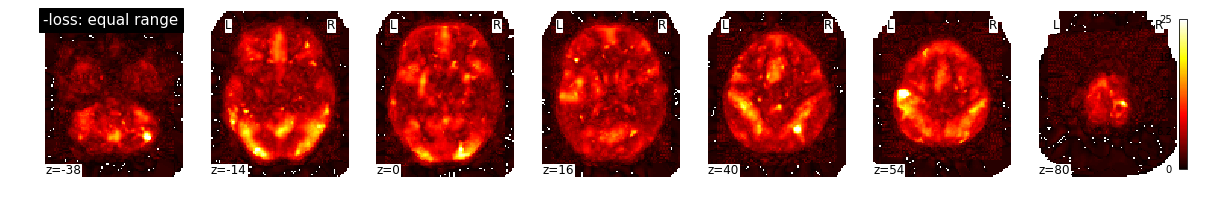

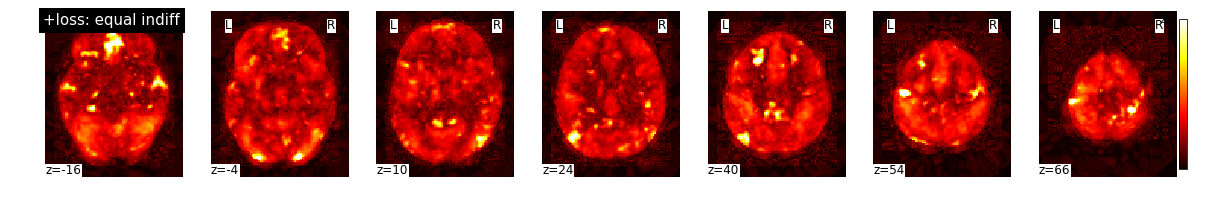

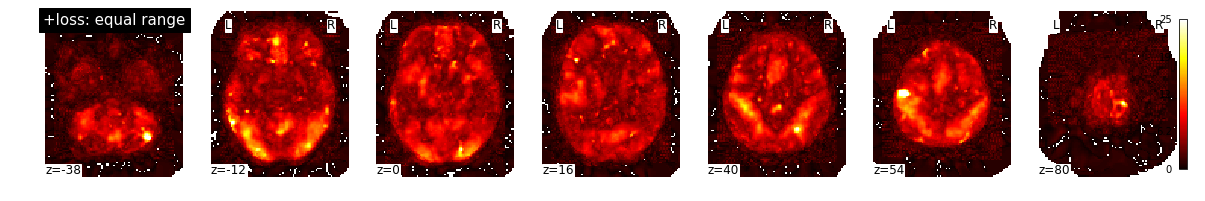

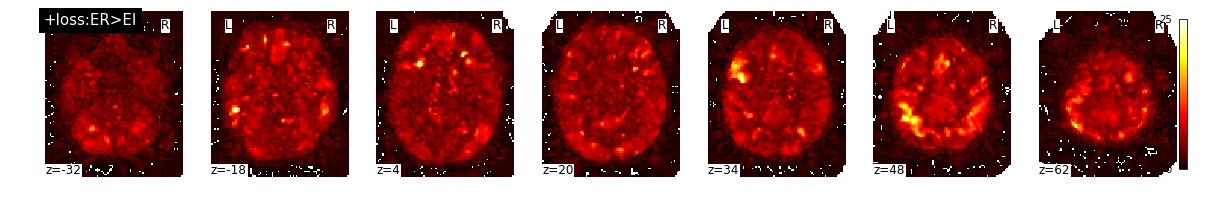

In [95]:
# show range maps
for hyp in [1,2,5,6,7,8,9]:
    range_img=nibabel.load(os.path.join(output_dir,'unthresh_range/hypo%d.nii.gz'%hyp))
    nilearn.plotting.plot_stat_map(range_img, threshold=.1, display_mode="z", 
                           colorbar=True,title=hypotheses[hyp],vmax=25,
                                  cut_coords = cut_coords)


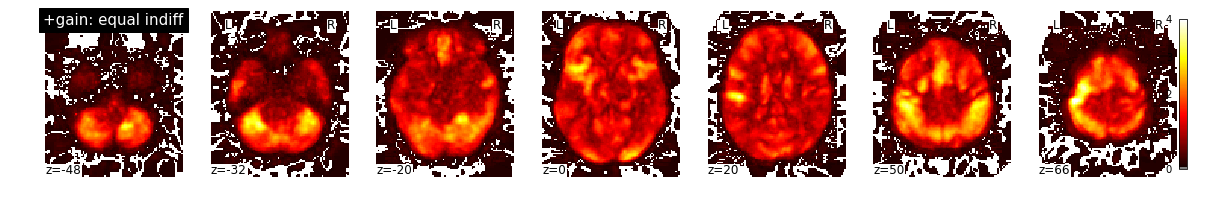

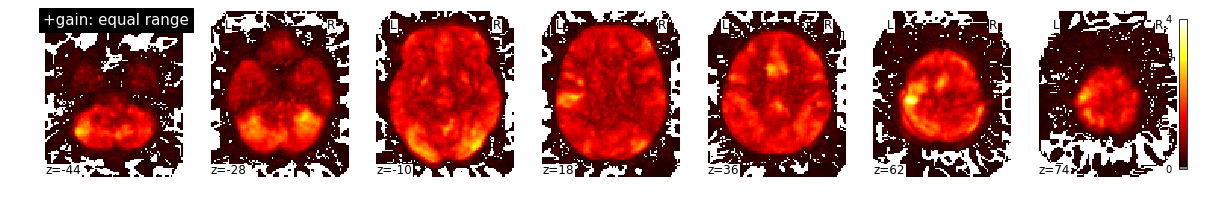

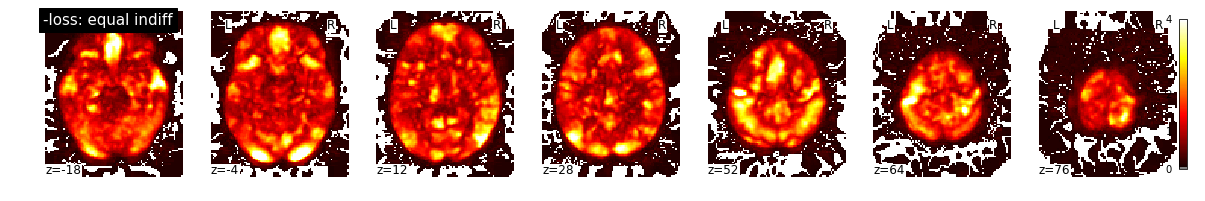

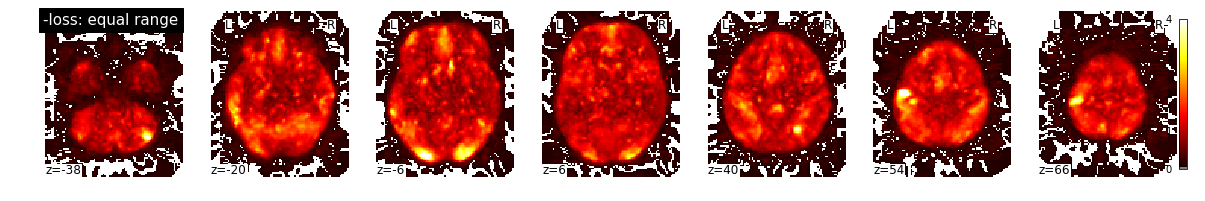

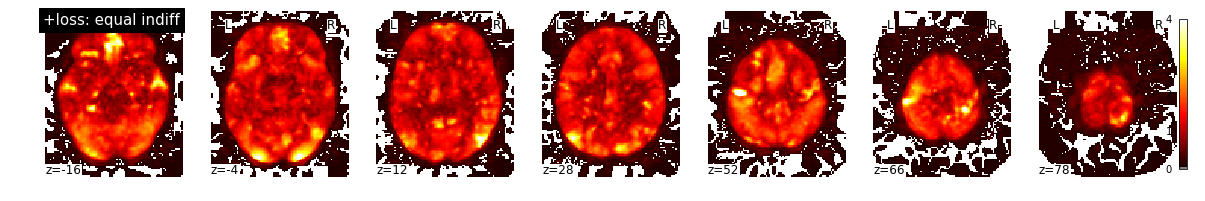

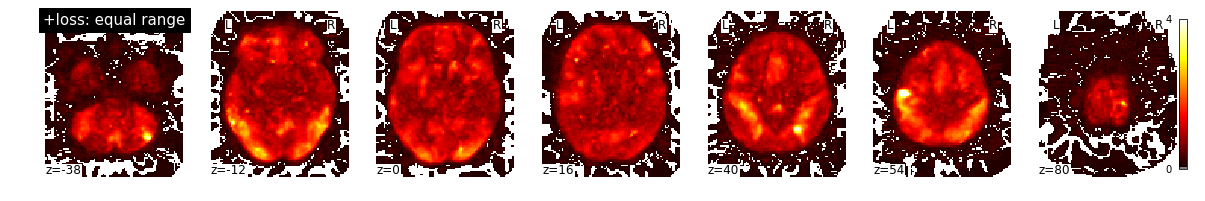

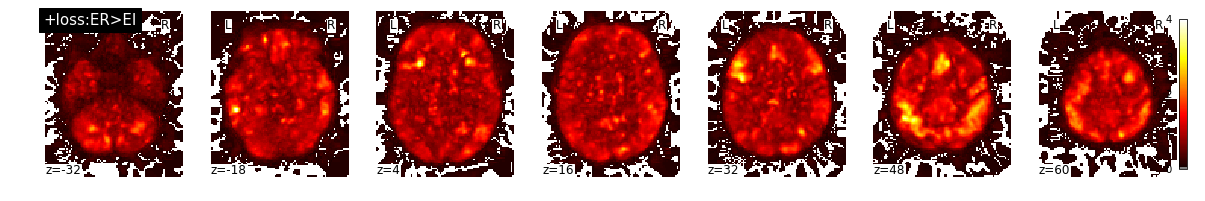

In [16]:
# show std maps
for hyp in [1,2,5,6,7,8,9]:
    std_img=nibabel.load(os.path.join(output_dir,'unthresh_std/hypo%d.nii.gz'%hyp))
    nilearn.plotting.plot_stat_map(std_img, threshold=.1, display_mode="z", 
                           colorbar=True,title=hypotheses[hyp],vmax=4,cut_coords = cut_coords))


Display unthresholded maps 

YZFBWTVU_Q6O0 (91, 109, 91) 902629 808355719353

FKMCNBTL_B5I6 (91, 109, 91) 902629 806777021232

RIIVGRDK_E3B6 (91, 109, 91) 902629 814739111641

IZREEBAR_T54A (91, 109, 91) 902629 807442258805

COXUJKNY_R9K3 (91, 109, 91) 902629 803158381571

PVRJCPGN_X19V (91, 109, 91) 902629 806437632728

QDWZHJWT_L7J7 (91, 109, 91) 902629 802268389377

CQCJIRXE_O03M (91, 109, 91) 902629 803626846022

WLJQPTCD_O6R6 (91, 109, 91) 902629 636895925029

WRZSQULI_B23O (91, 109, 91) 902629 805989026115

FLSSDFOD_9T8E (91, 109, 91) 902629 814739111641

QTIWKLGM_O21U (91, 109, 91) 902629 805701087464

IYQMMKMM_UI76 (91, 109, 91) 902629 805135139081

DLIKXMQO_3TR7 (91, 109, 91) 902629 814739111641

LNYOVSMV_50GV (91, 109, 91) 902629 807402543129

ADFZYYLQ_C88N (91, 109, 91) 902629 803486938527

PPCCKOJA_0JO0 (91, 109, 91) 902629 814739111641

EPBGXICO_I07H (91, 109, 91) 902629 807692287038

BEWWYWBV_5G9K (91, 109, 91) 902629 814739111641

LOMXBZWB_U26C (91, 109, 91) 902629 806987333789

MBCQRMVG_J7F9 (91, 1

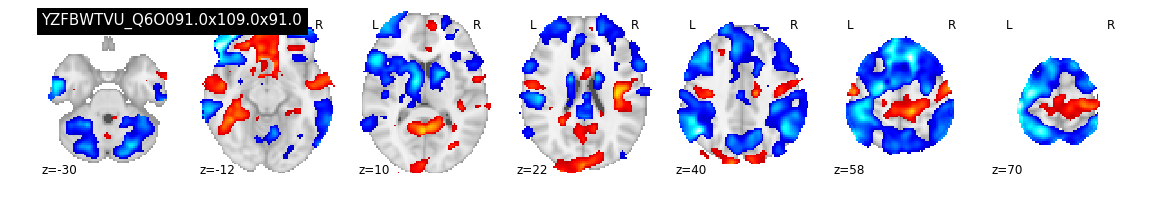

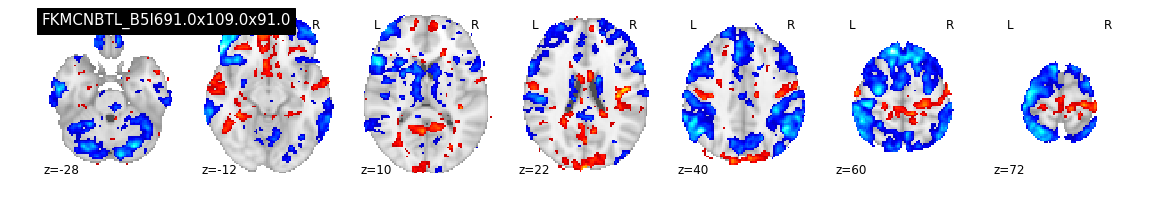

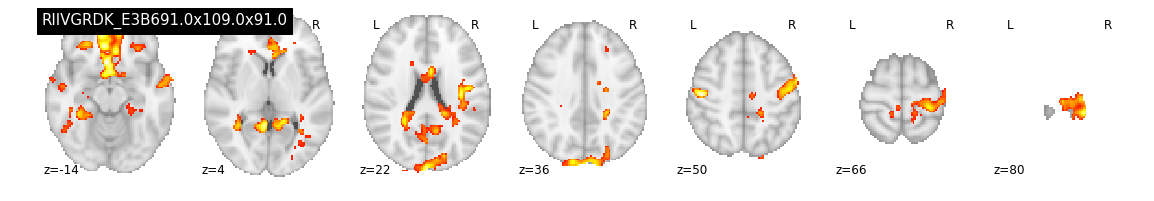

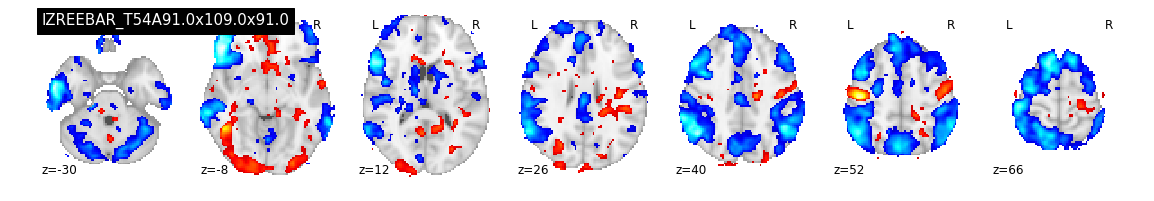

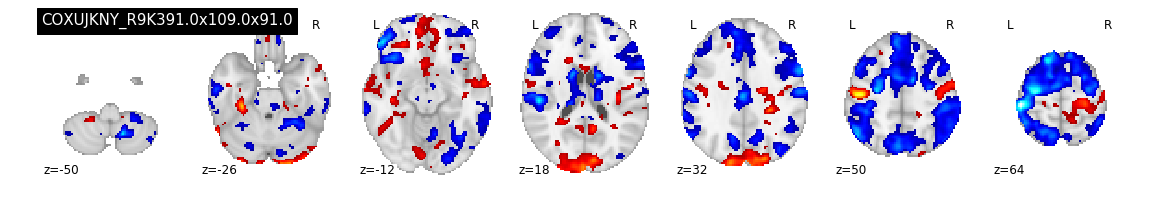

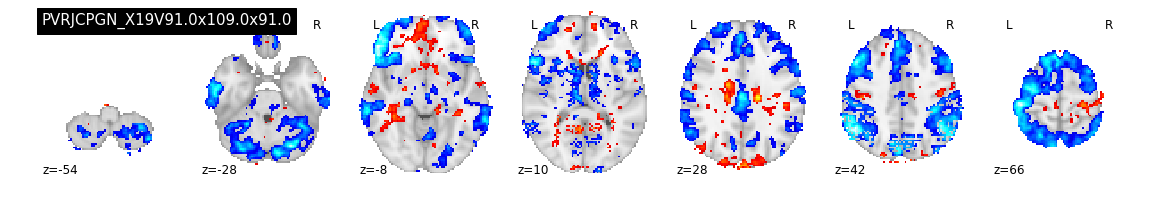

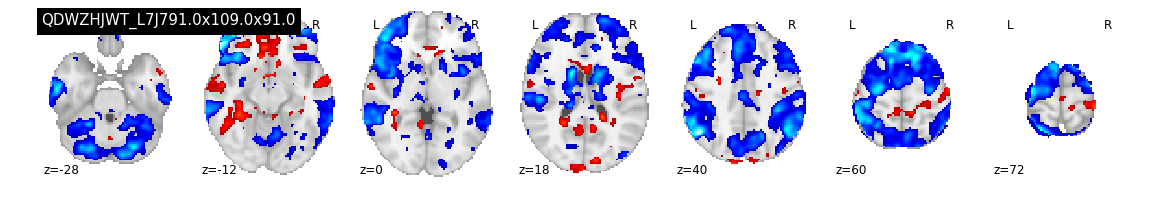

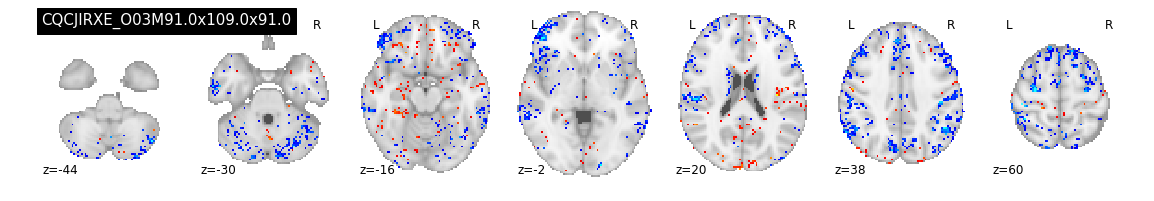

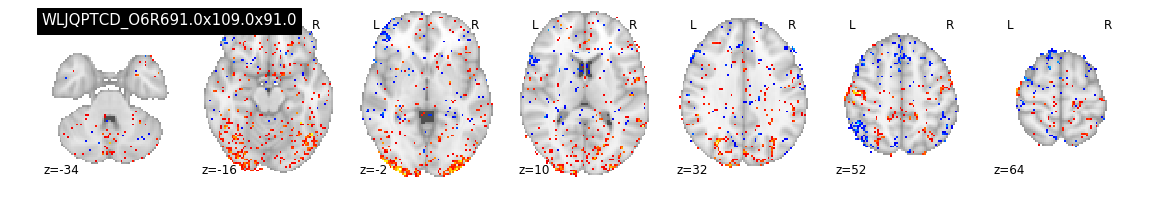

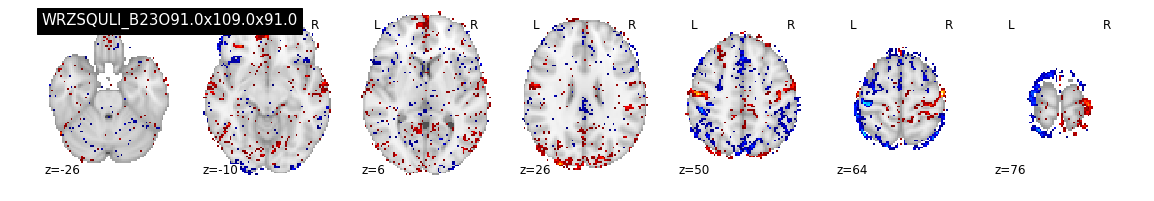

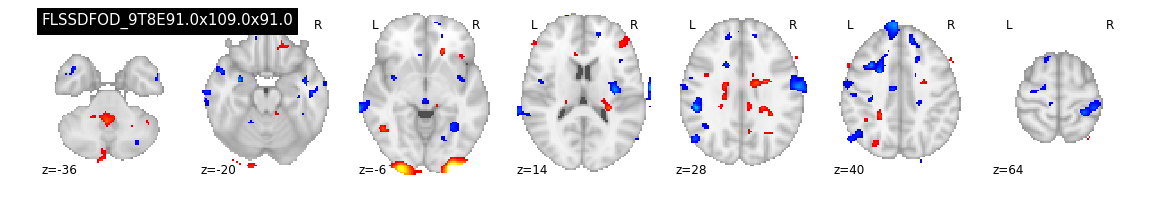

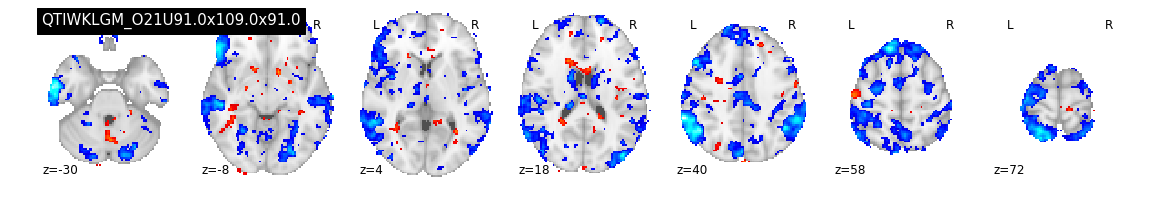

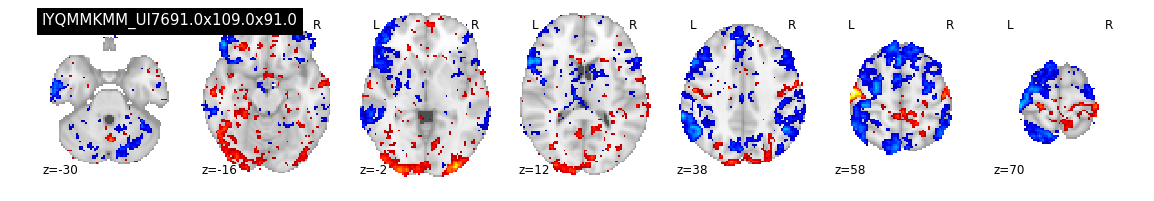

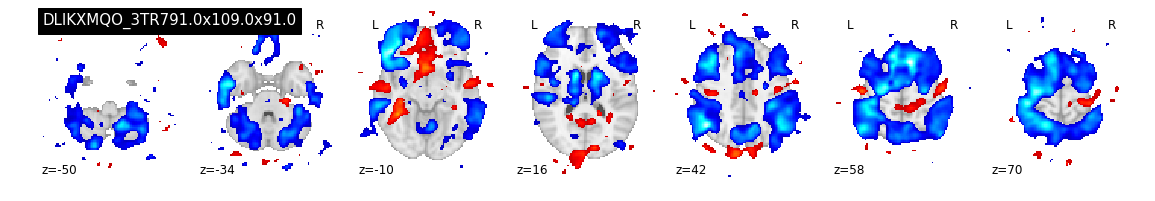

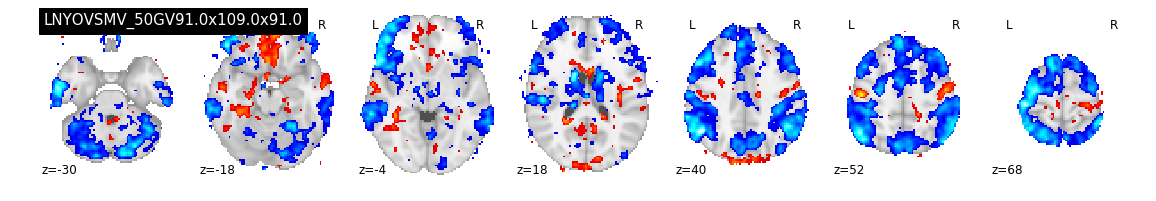

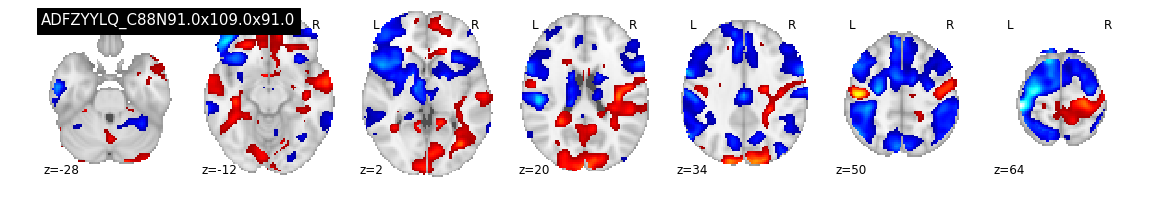

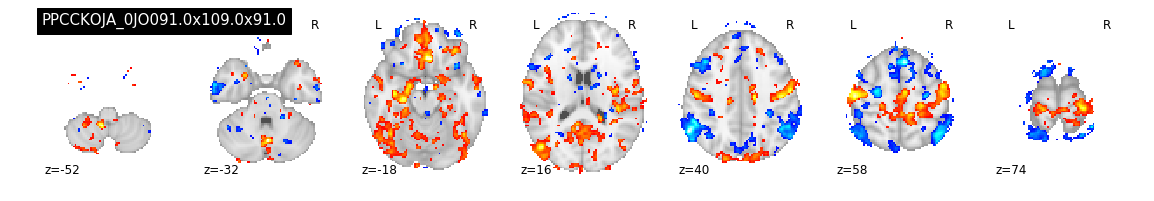

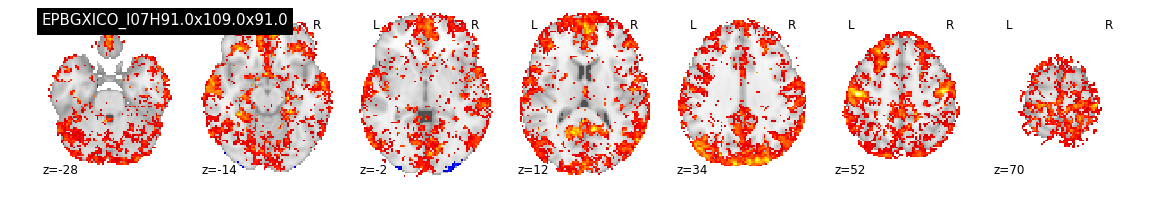

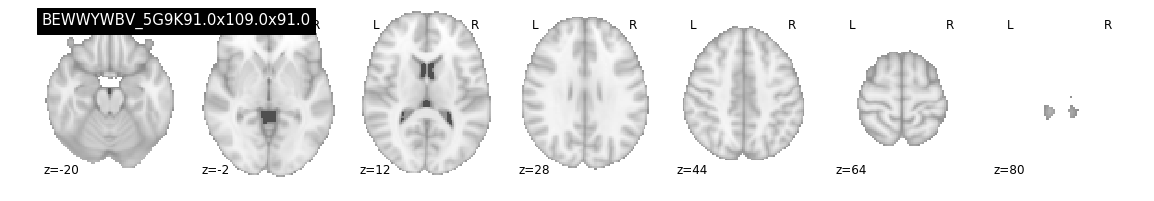

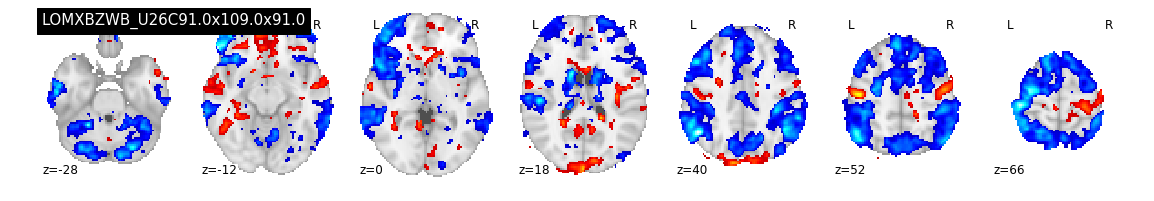

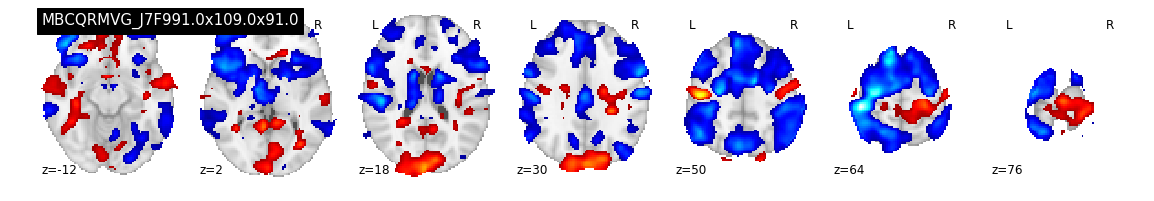

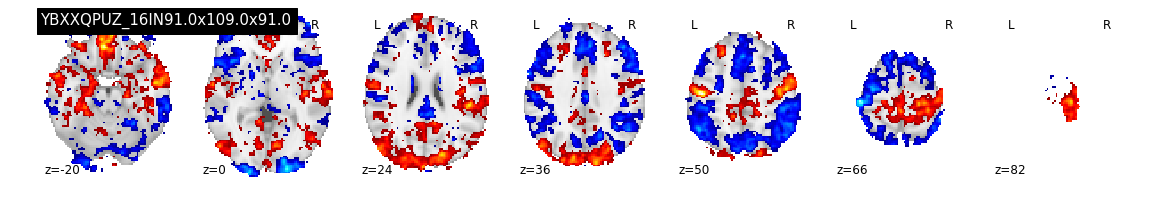

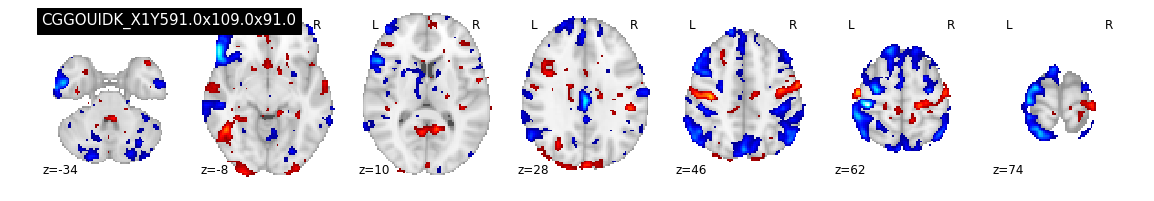

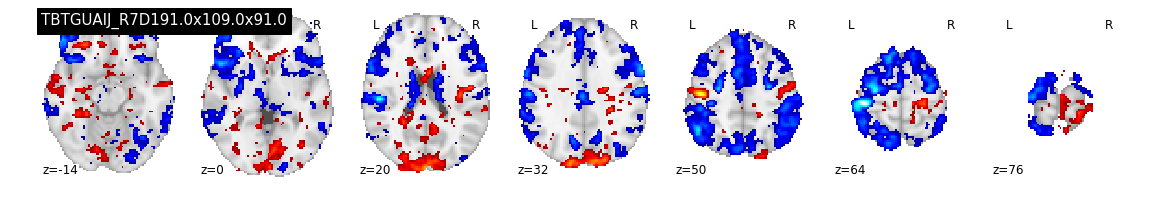

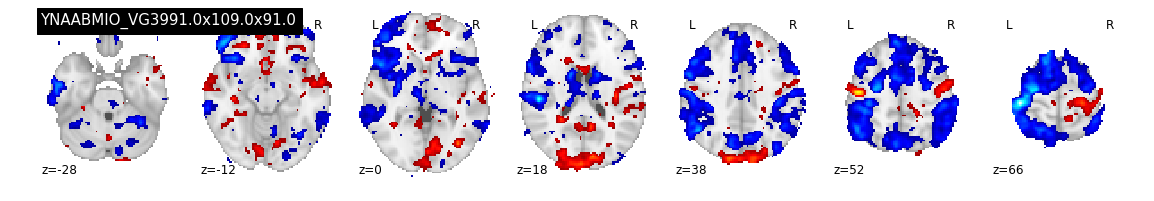

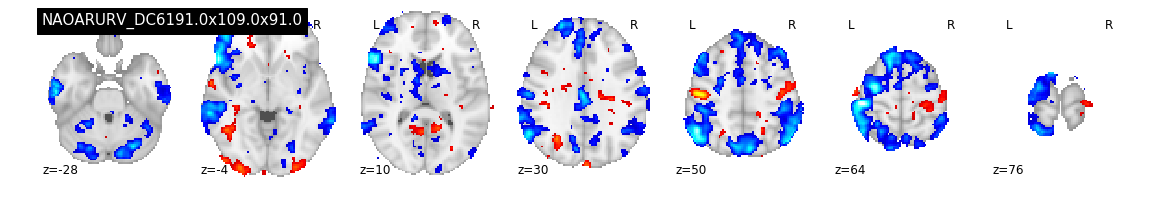

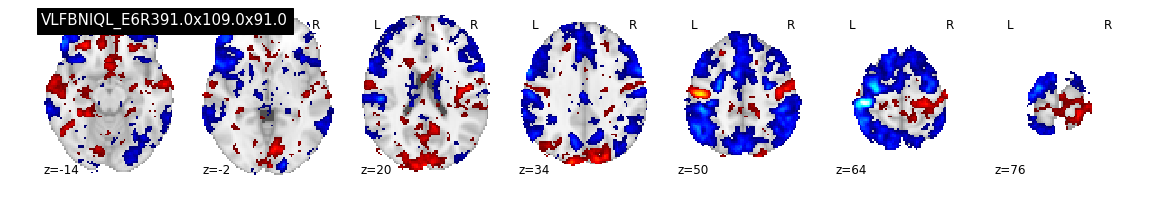

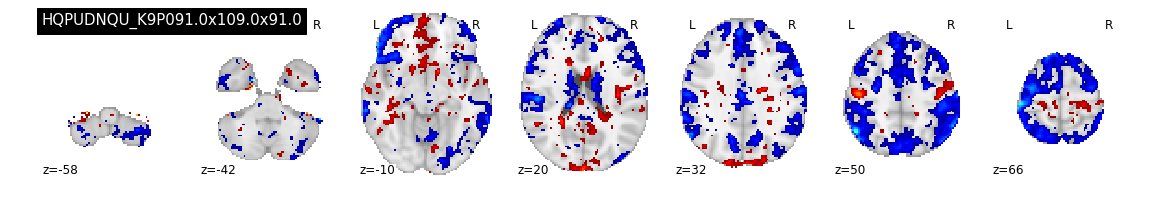

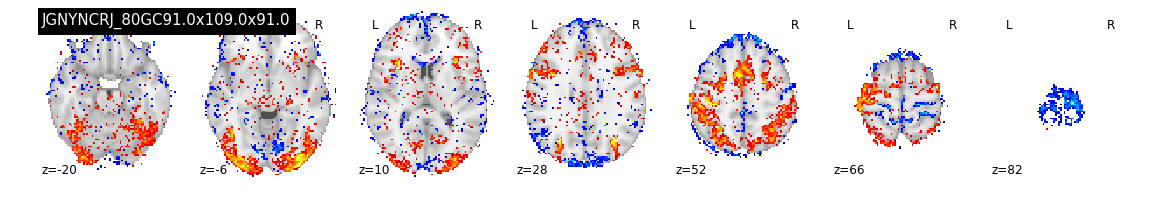

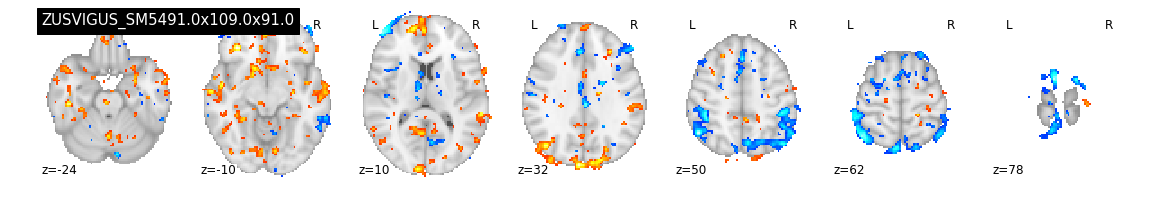

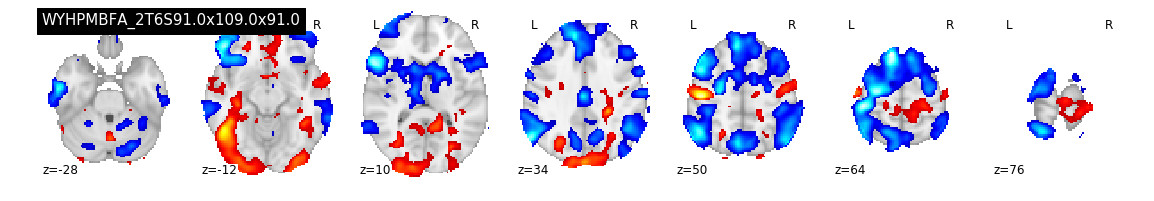

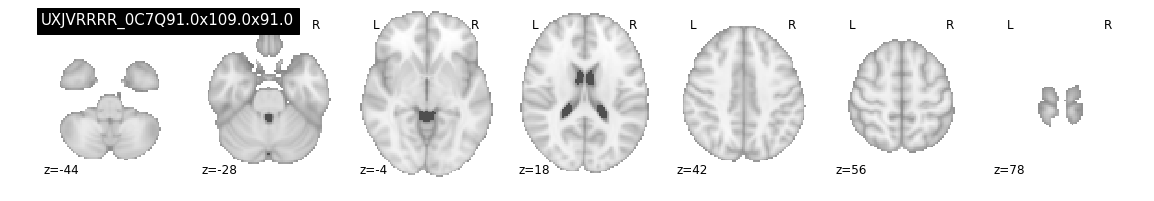

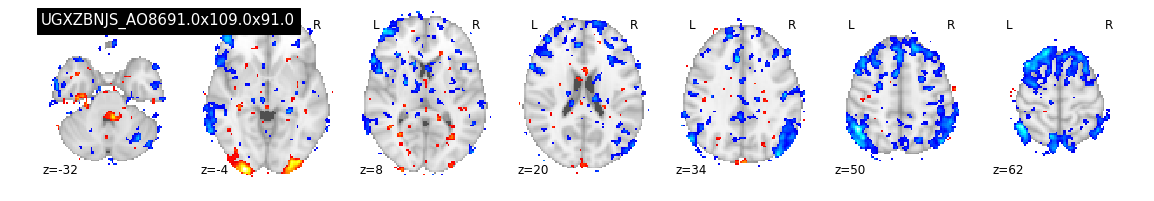

In [96]:
imgtype='unthresh'
imginfo = {}
plot_data=True
use_fmriprep_only=True
show_md = False
nnz = []
nonzero_volume = []

dim_values = []
missing_metadata = []

for hyp in range(1,2):
    hmaps = glob.glob(os.path.join(output_dir,'resampled/*/hypo%d_unthresh.nii.gz'%hyp))
    
    # load all maps and get dims
    for m in hmaps:
        img = nibabel.load(m)
        collection = m.split('/')[-2]
        collection_string,teamID = collection.split('_')
        dims = img.header.get_data_shape()
        dim_values.append(dims)
        
        md = metadata.query('NV_collection_string == "%s"'%collection_string)
        if md.shape[0]==0:
            # try other identifier
            md = metadata.query('teamID == "%s"'%teamID)
            if md.shape[0]==0:
                missing_metadata.append(collection)
                continue
        if use_fmriprep_only:
            if not md['used_fmriprep_data'].values[0].find('Yes')>-1:
                continue
            # also check space
            #if not ((numpy.prod(dims)==903555) and 
            #        (numpy.abs(numpy.prod(numpy.diag(img.header.get_qform())))==8)):
            #    continue
        qform = img.header.get_qform()
        #print(m)
        #print()
        #print(qform)
        # check for thresholding
        imgdata=img.get_data()
        nonzero_vox = numpy.nonzero(imgdata)
        n_nonzero_vox = len(nonzero_vox[0])
        nnz.append(n_nonzero_vox)
        vox_vol = numpy.prod(dims)
        nonzero_volume.append(n_nonzero_vox*vox_vol)
        print(collection,dims, numpy.prod(dims),n_nonzero_vox*vox_vol)
        if show_md:
            print(md['inter_subject_reg'].values)
        print('')
        if plot_data:
            nilearn.plotting.plot_stat_map(img, threshold=2., display_mode="z", 
                           colorbar=False,title=collection+'x'.join(['%0.1f'%i for i in dims[:3]]),
                                          cut_coords = cut_coords))
        
    #combined_img = nilearn.image.concat_imgs(hmaps)
    #combined_img.to_filename(os.path.join(output_dir,'thresh/hypo%d_combined_fmriprep.nii.gz'%hyp))

In [6]:
# load all images for hypothesis 1 and perform tsne

def get_masked_data(hyp,imgtype='unthresh'):
    if imgtype == 'unthresh':
        hmaps = glob.glob(os.path.join(output_dir,'resampled/*/hypo%d_unthresh.nii.gz'%hyp))
    else:
         hmaps = glob.glob(os.path.join(output_dir,'resampled/*/hypo%d_thresh.nii.gz'%hyp))
       
    combined_data = nilearn.image.concat_imgs(hmaps)
    masker = nilearn.input_data.MultiNiftiMasker(mask_img=os.path.join(output_dir,'templates/MNI152_T1_2mm_brain_mask.nii.gz'))
    maskdata=masker.fit_transform(combined_data)   
    maskdata = numpy.nan_to_num(maskdata)
    if imgtype=='thresh':
        maskdata = (maskdata>1e-6).astype('float')
    labels = [os.path.basename(os.path.dirname(i)).split('_')[1] for i in hmaps]
    return(maskdata,labels)
    

(60, 228483)

In [135]:
tsne = sklearn.manifold.TSNE()
tsne_fit = tsne.fit_transform(maskdata)
mds = sklearn.manifold.MDS()
mds_fit = mds.fit_transform(maskdata)

/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


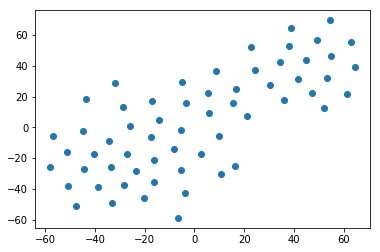

In [136]:
plt.scatter(tsne_fit[:,0],tsne_fit[:,1])

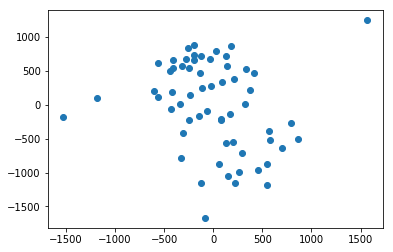

In [137]:
plt.scatter(mds_fit[:,0],mds_fit[:,1])

/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


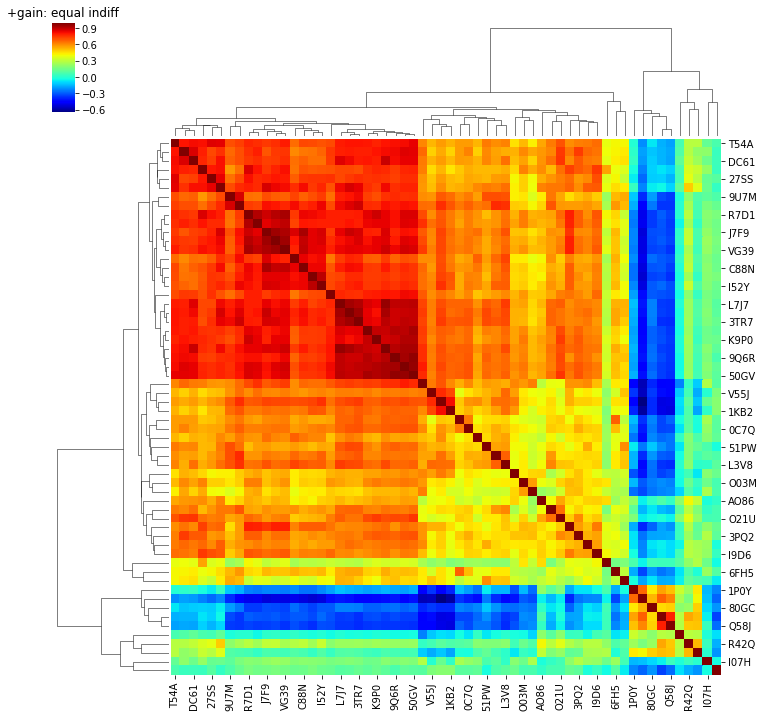

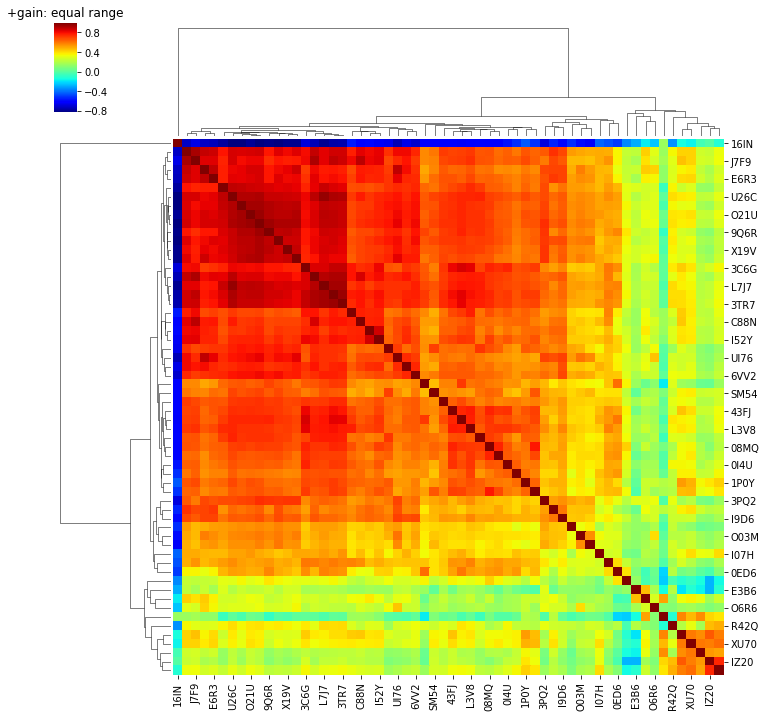

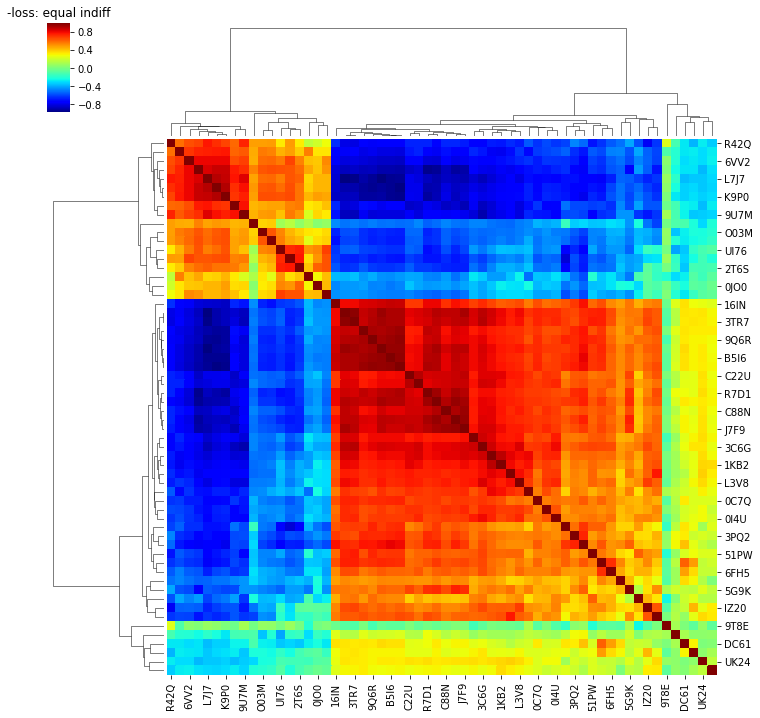

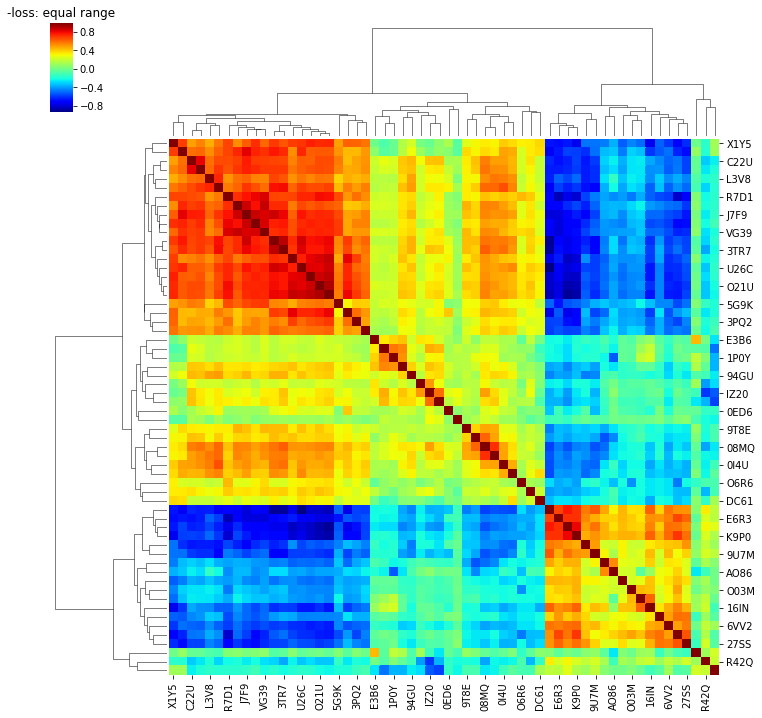

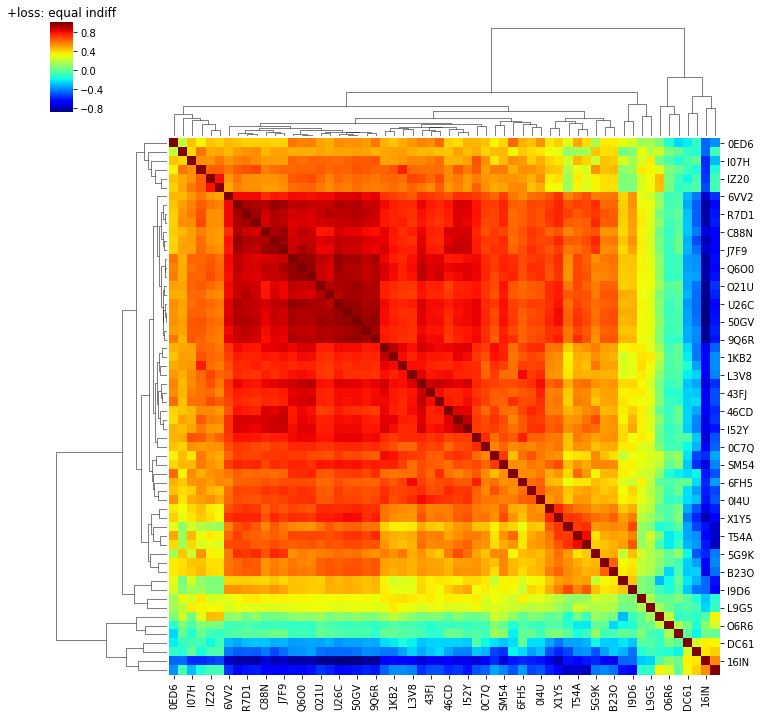

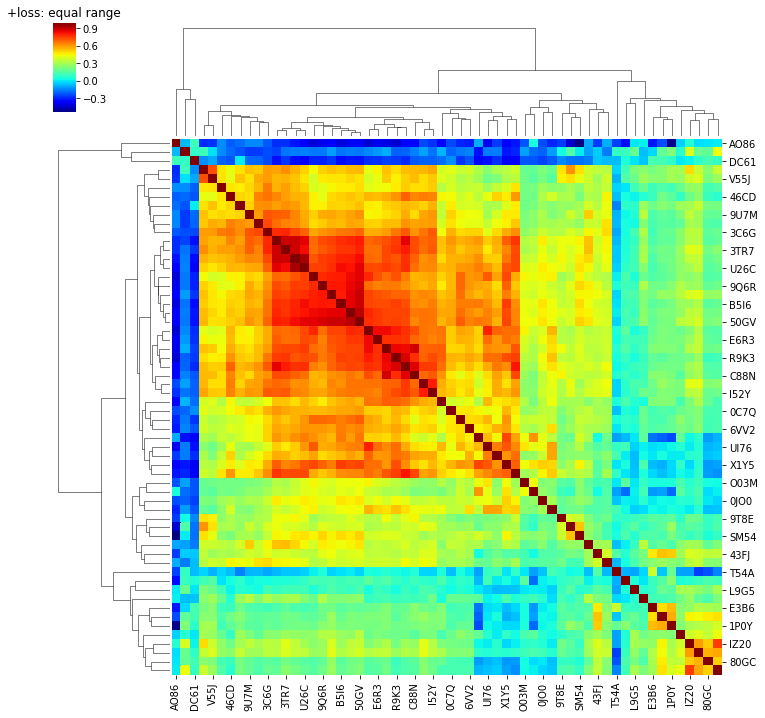

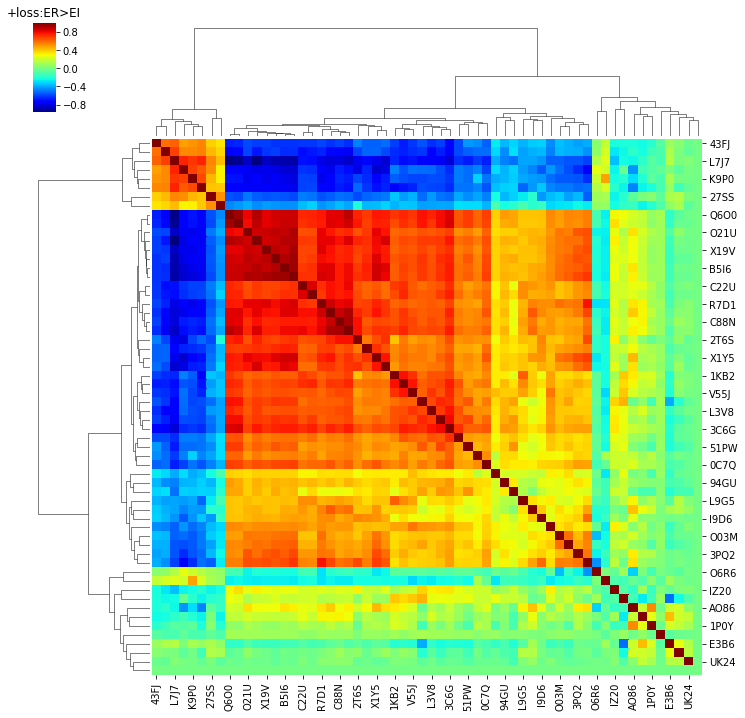

In [9]:
cc_unthresh={}
for hyp in [1,2,5,6,7,8,9]:
    maskdata,labels = get_masked_data(hyp)

    cc = numpy.corrcoef(maskdata)
    cc = numpy.nan_to_num(cc)
    df = pandas.DataFrame(cc,index=labels,columns=labels)
    seaborn.clustermap(df,cmap='jet',figsize=(12,12))
    plt.title(hypotheses[hyp])
    cc_unthresh[hyp]=(cc,labels)

In [7]:
import sklearn.metrics
def matrix_jaccard(mtx):
    jacmtx = numpy.zeros((mtx.shape[0],mtx.shape[0]))
    for i in range(mtx.shape[0]):
        for j in range(i+1,mtx.shape[0]):
            if i==j:
                 continue
            if numpy.sum(mtx[i,:])>0 and numpy.sum(mtx[j,:])>0:
                jacmtx[i,j]=sklearn.metrics.jaccard_score(mtx[i,:],mtx[j,:]) 
    
    jacmtx = numpy.nan_to_num(jacmtx)
    jacmtx = jacmtx + jacmtx.T
    jacmtx[numpy.diag_indices_from(jacmtx)]=1
    return(jacmtx)



/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:778: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples.
  'true or predicted', average, ('jaccard',))
/Users/poldrack/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:778: UndefinedMetricWarning: Jaccard is ill-defined and being se

KeyboardInterrupt: 

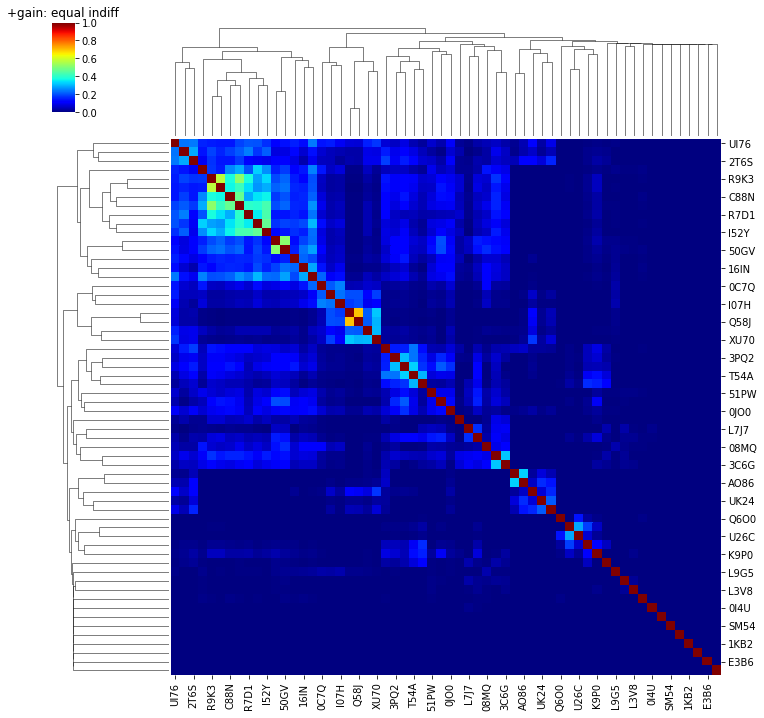

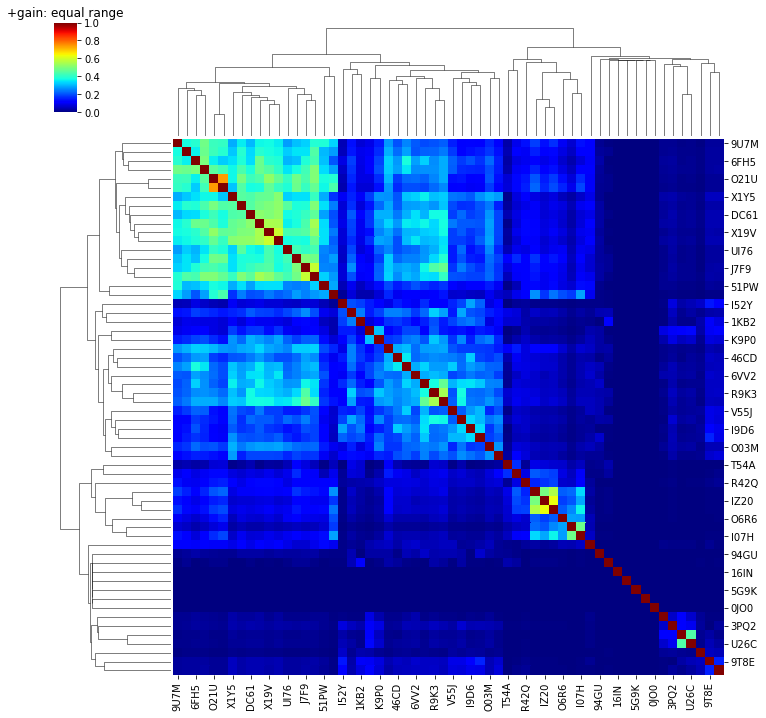

In [8]:
cc_thresh={}
for hyp in [1,2,5,6,7,8,9]:
    maskdata,labels = get_masked_data(hyp,imgtype='thresh')

    cc = matrix_jaccard(maskdata)
    df = pandas.DataFrame(cc,index=labels,columns=labels)
    seaborn.clustermap(df,cmap='jet',figsize=(12,12))
    plt.title(hypotheses[hyp])
    cc_thresh[hyp]=cc
    

In [ ]:
# how is it that VMPFC agreement is so good for negative loss but not for positive gain?


In [ ]:
# compute map similarity for fmriprep studies versus others

for hyp in [1]:
    cc,labels = cc_unthresh[hyp]
    